In [1]:
import os
import numpy as np
import matplotlib
import torch

import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

from scipy import signal

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import LeaveOneGroupOut






In [ ]:
class Net2(nn.Module):
    def __init__(self,in_channels, num_classes):
        super(Net2,self).__init__()
        n_ch = in_channels  # channel of input 
        n1 = 200  # This directly affects accuracy if value is low.
        n2 = 100
        n3 = 50
        n4 = 50
       
 
        n_l1=4200
        n_l2=200
       
      
        self.conv1 = nn.Conv2d(n_ch, n1, (10, 3),2)
        self.bn1 = nn.BatchNorm2d(n1)
        #self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv2d(n1, n2, (5, 3),2)
        
        self.bn2 = nn.BatchNorm2d(n2)
        self.conv3 = nn.Conv2d(n2, n3, (5, 2),2)
        self.bn3 = nn.BatchNorm2d(n3)
        self.conv4 = nn.Conv2d(n3, n4, (5, 2),2)
        self.bn4 = nn.BatchNorm2d(n4)
        # self.conv5 = nn.Conv2d(n4, n5, 2)
        # self.bn5 = nn.BatchNorm2d(n5)
     
        
        self.fc1 = nn.Linear(n_l1, n_l2)
       
   
        self.fc2 = nn.Linear(n_l2, num_classes)
      
        


    def forward(self, x):
      
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        #x = self.pool1(x)
        #print(x.shape)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        #print(x.shape)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        #print(x.shape)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        # x = self.conv5(x)
        # x = F.relu(self.bn5(x))
        # x = self.pool1(x)
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
       
        x = self.fc2(x)
       
        
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
file_name_train=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/Data_allfilt_0.5_7.mat"
file_name_train=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/Data_all2.mat"

data = scipy.io.loadmat(file_name_train)
feature_all = data['feature_all'][:,:,:]   ## waveform * channel * case 
feature_all=np.swapaxes(feature_all,0,2)
self_channel=[0,1,10,11,20,21,30,31]
#self_channel=[30]
feature_all_ch=feature_all[:,self_channel,:]   ## case * channel * waveform

feature_all_norm = data['feature_all_norm'][:,:,:]
feature_all_norm=np.swapaxes(feature_all_norm,0,2)
feature_all2=np.concatenate((feature_all, feature_all_norm), axis=1)

label_all = data['label_all']
caseNum_all = data['caseNum_all']
label_all_1 = data['label_all_1']
label_all_2 = data['label_all_2']
Chan_Name = data['Chan_Name']

fs=500
# delete some cases with high testing accuracy
del_case=[1,2,9]
del_case=[1,2,7,9]

idx=[]
for i in del_case:
  temp = np.where(caseNum_all==i)
  for element in temp[0].flatten():
    idx.append(element)
  
idx=np.array(idx).flatten().astype("int")

caseNum_all_del=np.delete(caseNum_all,idx)
label_all_del=np.delete(label_all,idx)
label_all_del1=np.delete(label_all_1,idx)
label_all_del2=np.delete(label_all_2,idx)
feature_all2_del=np.delete(feature_all2,idx,axis=0)
feature_all_del=np.delete(feature_all,idx,axis=0)
feature_all_norm_del=np.delete(feature_all_norm,idx,axis=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:




def WT(dataIn):
  Ds=5
  fs=500/Ds
  dataIn = signal.resample(dataIn, int(dataIn.shape[2]/Ds),axis=2)
  f=np.linspace(0.2,10,60)  # freqeucny range 
  widths =np.round(fs/f)  # frequency to widths range 

  Zxx_all=np.zeros([dataIn.shape[0],dataIn.shape[1],dataIn.shape[2],60])
  for i in range(dataIn.shape[0]):
    for j in range(dataIn.shape[1]):
      phase_data=dataIn[i,j,:]
     
      cwtmatr = signal.cwt(phase_data, signal.ricker, widths) # CWT transform 
      Zxx_out=cwtmatr.T 
      Zxx_all[i,j,:,:]=abs(Zxx_out)
  Zxx_all=np.array(Zxx_all)  
  return Zxx_all
    
feature_2d=WT(feature_all_del)
X=feature_2d;
y=label_all_del;


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
f=np.linspace(0.2,10,60)
ind_equa=np.where(np.logical_and(f>1, f<2))[0]
feature_2d_equa=feature_2d
feature_2d_equa[:,:,:,ind_equa]=feature_2d_equa[:,:,:,ind_equa]*10


0.11956011497222625
0.12339554939951215
0.06138729565852397
0.07762755240712847
0.031228868005511997
0.06034010648727417
0.016094269583354127
0.03900799048798425
0.0069259789914966705
0.040896752050944736
0.0030694648640247077
0.04607475974730083
0.0012863754286422386
0.04339541069098881
0.0009455801919102669
0.04611585661768913
0.0005164349594296098
0.04568709220205035
0.0004258877031404424
0.04577676419700895
0.00037114292399974556
0.04680176451802254
0.0002545360066751773
0.04673894973737853
0.00021999380089812452
0.04678842957530703
total training time is 30.73190140724182


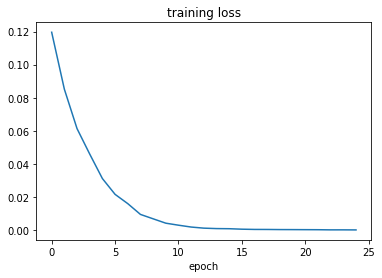

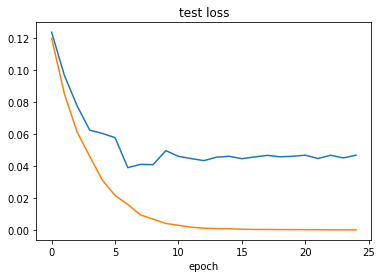

In [ ]:
X=feature_2d_equa;
y=label_all_del;

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import torch
torch.cuda.empty_cache()
if __name__ == '__main__':
    
    
    batchsize_train = 16

    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
    batchsize_test = 16
    test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)
            
    
    #hyperparameter definition    
    #learning_rate = 0.001 
    learning_rate = 1e-4  #学习的速率 越小越精细
    momentum = 0.1
    random_seed=1
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)     #设定随机数种子为固定值
    
    train_loss_epoch = []
    test_acc_epoch =[]
    total_acc_epoch = []
    #epoch_range = np.arange(25,225,25)
    epoch_range = np.array([2])

    
    #network = Net2().cuda()   # 2d cnn
    network = Net2(32,8).cuda()   # 1d cnn

    
    #training
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
    

    #network.train()
    Training_Loss = []
    Test_Loss = []
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3]).cuda())
    for epoch in range(25):   # loop over the dataset multiple times
        train_loss = 0
        for X, Y in train_loader:
            # X = X.view(-1,1,X.shape[2],X.shape[3]).cuda()
            X = X.float().cuda()  
            Y = Y.long().view(-1, ).cuda() 
            current_batchsize = X.shape[0]
            optimizer.zero_grad()
            output = network(X)
            loss = criterion(output,Y)
            train_loss = train_loss + loss.item()
            loss.backward()                     #calculate the gradient decent
            optimizer.step()                    #update the weight
            
          





        test_loss = 0
        correct = 0
        total = 0
        test_y= []
        test_y_p = []
        # sens = 0    # sensitivity = TP/(TP + FN)
        # prec = 0    # precision = TP/(TP + FP)
        with torch.no_grad():        
            # X = X.view(-1,X.shape[1],X.shape[2])
            # X = X.float()         
            for X, Y in test_loader:
                X = torch.Tensor(X).cuda()
                Y = torch.Tensor(Y).long().view(-1, ).cuda()
                images, labels = X, Y
                # calculate outputs by running images through the network
                outputs = network(images)
                loss = criterion(outputs,Y)
                test_loss = test_loss + loss.item()

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                for i in range(len(labels)):
                  test_y.append(labels[i])
                  test_y_p.append(predicted[i])
        
        #print('Accuracy of test cases: %d %%' % (100 * correct / total))
 

        Training_Loss.append(train_loss/len(train_loader.dataset))
        Test_Loss.append(test_loss/len(test_loader.dataset))
        if epoch%2==0:
            print(train_loss/len(train_loader.dataset))
            print(test_loss/len(test_loader.dataset))
      
            

    
    train_loss_epoch.append(Training_Loss[-1])
    training_time=time.time()-start_time
    print('total training time is',training_time)
    
    plt.figure()
    plt.plot(Training_Loss)
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.show()

    plt.figure()
    plt.plot(Test_Loss)
    plt.title("test loss")
    plt.xlabel("epoch")
    plt.plot(Training_Loss)
    plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix
import scipy.io
import seaborn as sn
import pandas as pd
test_y_p=torch.FloatTensor(test_y_p)
test_y=torch.FloatTensor(test_y)
y_p=np.array(test_y_p.cpu())
y=np.array(test_y.cpu())




cm=confusion_matrix(y, y_p)
acc=accuracy_score(y, y_p)
print(cm,acc)

[[7 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0]
 [0 1 0 5 0 0 0 0]
 [0 0 0 0 7 0 0 0]
 [0 0 1 0 0 3 3 2]
 [0 0 0 1 0 0 3 0]
 [0 0 1 0 0 0 2 4]] 0.8035714285714286


In [ ]:
# in_ch: CNN input channel number 
# num_class: classification number  8,5,3 
# opt CV method. groupKfold: kfold, all cases not been seen in training set  
# Kfold : randomly kfold. label and cases equally distributed
# group: leave one case out 
    
def kFCV(X_all,y_all,in_ch,num_class,opt,case):


    
    rkf_group=StratifiedGroupKFold(n_splits=5)
    cm_all=[]
    acc_all=[]
    
    case=case.flatten()
    if opt=='groupKfold':
        folds=StratifiedGroupKFold(n_splits=5).split(X_all,y_all,case)
    if opt=='Kfold':
        folds=RepeatedStratifiedKFold(n_splits=5, n_repeats=1,random_state=0).split(X_all,case)
    if opt=='group':  
        logo = LeaveOneGroupOut()
        logo.get_n_splits(X_all,y_all,case)
        logo.get_n_splits(groups=case) 
        folds=logo.split(X_all,y_all,case)

    for train_ind, test_ind in folds:
           
       
        X_train=X_all[train_ind] 
        X_test=X_all[test_ind]
        y_train=y_all[train_ind] 
        y_test=y_all[test_ind]
        
        # (unique, counts) = np.unique(caseNum_all[test_ind], return_counts=True)
        # frequencies = np.asarray((unique, counts)).T
        # print(frequencies)

        batchsize_train = 16
        train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
        batchsize_test = 16
        test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)
                
        
        n_epoch=25
        learning_rate = 1e-4  #学习的速率 越小越精细
        momentum = 0.1
        random_seed=1
        torch.backends.cudnn.enabled = False
        torch.manual_seed(random_seed)     #设定随机数种子为固定值
        
        train_loss_epoch = []
        test_acc_epoch =[]
        total_acc_epoch = []
        #epoch_range = np.arange(25,225,25)
        epoch_range = np.array([2])

        
        
        network = Net2(in_ch,num_class).cuda()   # 1d cnn

        
        #training
        optimizer = optim.Adam(network.parameters(), lr=learning_rate)
        
        
        
        #network.train()
        Training_Loss = []
        Test_Loss = []
        start_time = time.time()
        criterion = nn.CrossEntropyLoss()
        for epoch in range(n_epoch):   # loop over the dataset multiple times
            train_loss = 0
            for X, Y in train_loader:
                
                X = X.float().cuda()  
                Y = Y.long().view(-1, ).cuda() 
                current_batchsize = X.shape[0]
                optimizer.zero_grad()
                output = network(X)
                loss = criterion(output,Y)
                train_loss = train_loss + loss.item()
                loss.backward()                     #calculate the gradient decent
                optimizer.step()                    #update the weight
                

            test_loss = 0
            correct = 0
            total = 0
            test_y= []
            test_y_p = []
            # sens = 0    # sensitivity = TP/(TP + FN)
            # prec = 0    # precision = TP/(TP + FP)
            with torch.no_grad():        
                # X = X.view(-1,X.shape[1],X.shape[2])
                # X = X.float()         
                for X, Y in test_loader:
                    X = torch.Tensor(X).cuda()
                    Y = torch.Tensor(Y).long().view(-1, ).cuda()
                    images, labels = X, Y
                    # calculate outputs by running images through the network
                    outputs = network(images)
                    loss = criterion(outputs,Y)
                    test_loss = test_loss + loss.item()

                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    for i in range(len(labels)):
                      test_y.append(labels[i])
                      test_y_p.append(predicted[i])

            Training_Loss.append(train_loss/len(train_loader.dataset))
            Test_Loss.append(test_loss/len(test_loader.dataset))
            # if epoch%(n_epoch-1)==0:
            #     print(train_loss/len(train_loader.dataset))
            #     print(test_loss/len(test_loader.dataset))
      
        train_loss_epoch.append(Training_Loss[-1])
        test_y_p=torch.FloatTensor(test_y_p)
        test_y=torch.FloatTensor(test_y)
        y_p=np.array(test_y_p.cpu())
        y=np.array(test_y.cpu())


        cm=confusion_matrix(y, y_p)
        acc=accuracy_score(y, y_p)
        
        cm_all.append(cm)
        acc_all.append(acc)
    acc_all=np.array(acc_all)
    acc_mean=np.mean(acc_all) 
    cm_all=np.array(cm_all)
    cm=np.sum(cm_all, axis=0)
    

    print(acc_mean) 
    print(cm)
    return cm,acc_all,acc_mean

In [ ]:
feature_all_del2d=feature_2d

if __name__ == '__main__':
  
    #cm1,acc_all,acc1=kFCV(feature_all_del,label_all_del,in_ch=32,num_class=8,opt='group',case=caseNum_all_del)
  #  cm2,acc_all,acc2=kFCV(feature_all_del2d,label_all_del,in_ch=32,num_class=8,opt='groupKfold',case=caseNum_all_del)
   # cm2,acc_all2,acc2=kFCV(feature_all2d,label_all,in_ch=32,num_class=8,opt='group',case=caseNum_all)
    #cm1,acc_all1,acc1=kFCV(feature_all_del2d,label_all_del,in_ch=32,num_class=8,opt='group',case=caseNum_all_del)
    #cm2,acc_all2,acc2=kFCV(feature_all2d,label_all,in_ch=32,num_class=8,opt='group',case=caseNum_all)
    #cm2,acc_all2,acc2=kFCV(feature_all_del2d,label_all_del,in_ch=32,num_class=8,opt='groupKfold',case=caseNum_all_del)
    cm3,acc_all3,acc3=kFCV(feature_all_del2d,label_all_del,in_ch=32,num_class=8,opt='Kfold',case=caseNum_all_del)
    # cm4,acc_all4,acc4=kFCV(feature_all_del,label_all_del,in_ch=32,num_class=8,opt='group',case=caseNum_all_del)
    # cm5,acc_all5,acc5=kFCV(feature_all_norm_del,label_all_del,in_ch=32,num_class=8,opt='group',case=caseNum_all_del)
    #cm6,acc_all6,acc6=kFCV(feature_all_ch2_del,label_all_del,in_ch=2,num_class=8,opt='group',case=caseNum_all_del)

0.9031168831168831
[[27  0  0  0  0  0  0  0]
 [ 0 52  2  0  1  0  0  0]
 [ 0  0 54  0  1  0  0  1]
 [ 0  0  0 26  1  1  0  0]
 [ 0  0  0  1 26  0  1  0]
 [ 1  0  0  2  0 21  2  2]
 [ 0  0  0  0  1  1 25  1]
 [ 0  0  1  0  0  5  2 20]]


In [ ]:
print(acc_all3)

[0.875      0.89285714 0.875      0.92727273 0.94545455]


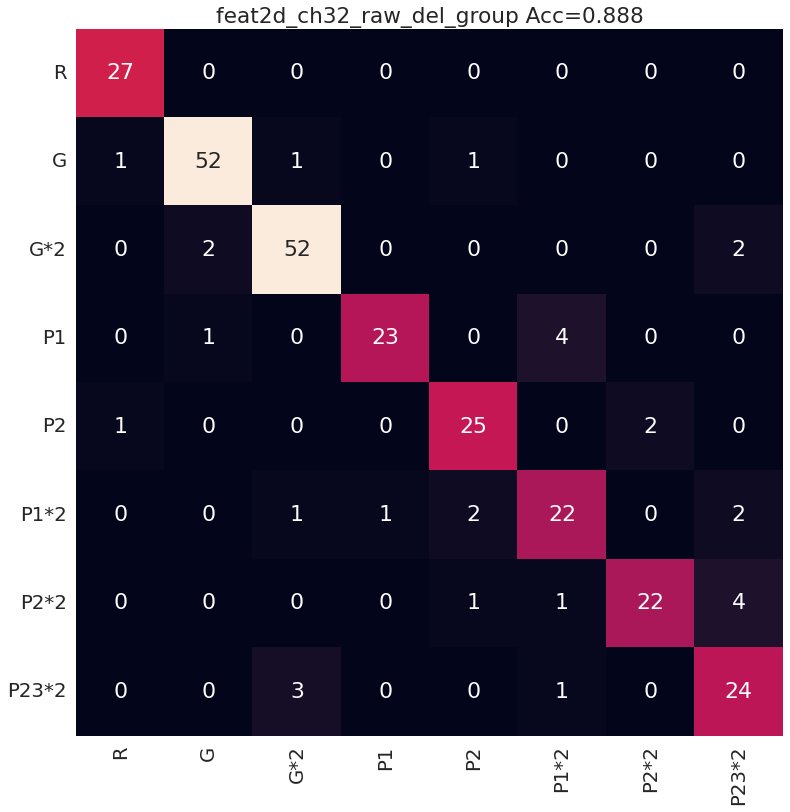

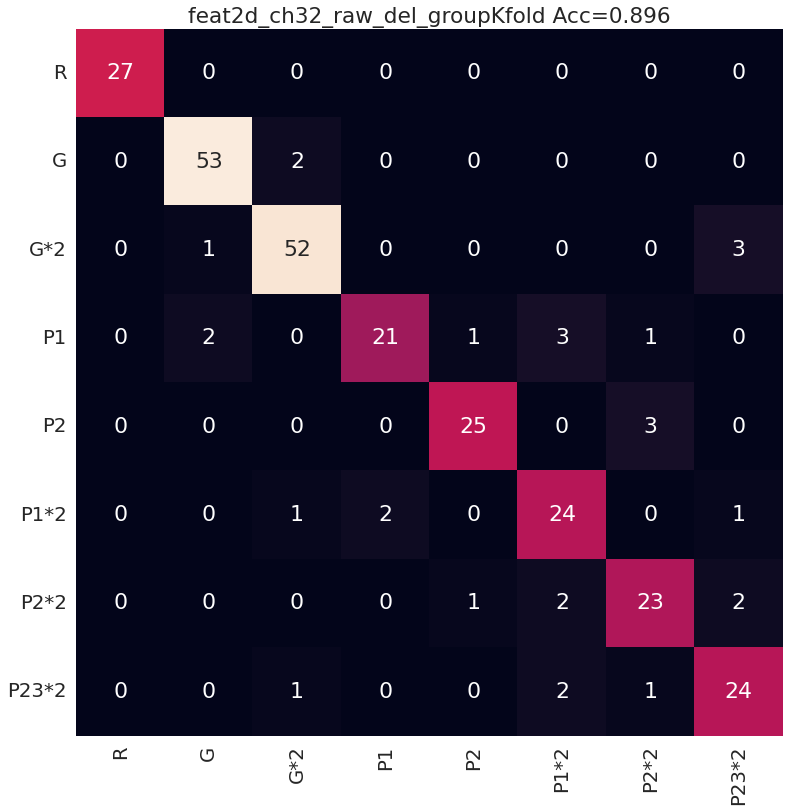

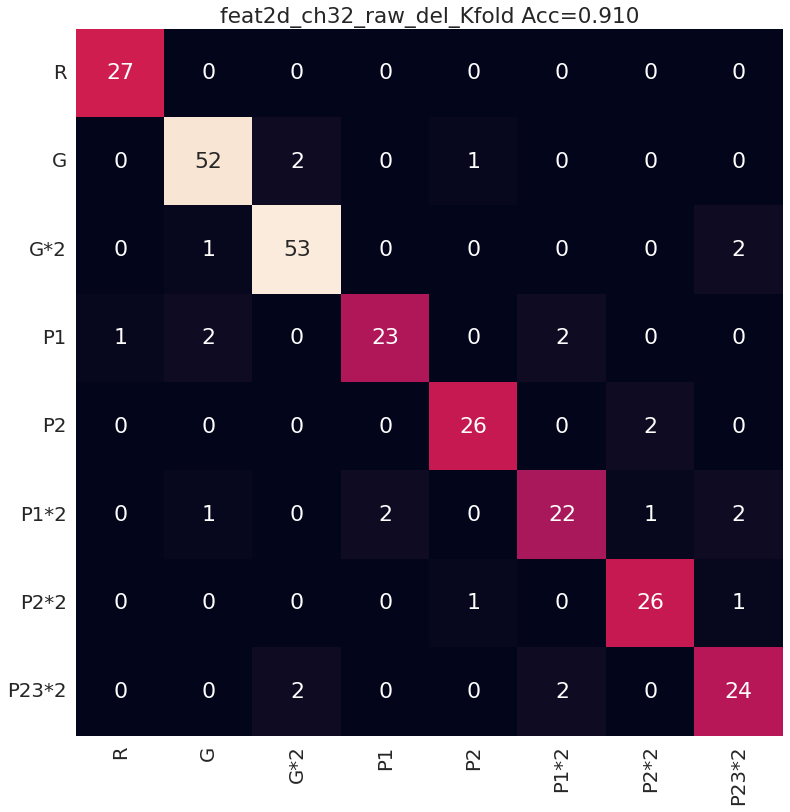

In [ ]:
parent_dir = r"/content/drive/My Drive/Colab Notebooks/RFMG/result_1220/"
path1 = os.path.join(parent_dir, 'fig')
os.makedirs(path1, exist_ok = True) 

def plotfigFullClass(cm,acc,tle):

    labelNum=str(1)  #labelling method 1,2,3,4
    size=18
    name1=["R", "G","G*2","P1","P2","P1*2","P2*2","P23*2"]
    name2=["R", "G","G*2","P1","P2","P1*2","P2*2","P23*2"]
    a=3
    b=12
    w=15 #fig size 1      change when label num change
    h=13   #fig size 2
    
    true_num=0
    for i in range (len(cm)):
      true_num=true_num+ cm[i,i]
    acc=true_num/np.sum(cm)   
    
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=1.8)
    sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size,'fontsize':22})
 
    s01=' Acc={n:.3f}'.format(n=acc)
    #plt.text(a,b,s01,fontsize=size)
    
    tleSave=tle
    plt.title(tle+s01)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    FolderSave=r"C:/Users/zz587-admin/Documents/sleep center paper/figure/python/cm_detect/"
    
    plt.savefig(parent_dir+r"fig/"+tleSave+"CM.png", dpi=300)

plotfigFullClass(cm1,acc1,'feat2d_ch32_raw_del_group')
plotfigFullClass(cm2,acc2,'feat2d_ch32_raw_del_groupKfold')
plotfigFullClass(cm3,acc3,'feat2d_ch32_raw_del_Kfold')
